## This notebook will do the ablation on SiamFC and tell you how it works!

In [1]:
import torch
import cv2
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import utils.siamese as siamese #where the network is
import collections
from PIL import Image, ImageStat
import numpy as np
import os
import h5py
import matplotlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib import cm as CM
%matplotlib inline

NET_PATH = 'backup/baseline-conv5_e55.weights'
Rectangle = collections.namedtuple('Rectangle', ['x', 'y', 'width', 'height'])
os.environ['CUDA_VISIBLE_DEVICES'] = '3'#define your gpu

/home/leeyh/anaconda2/lib/python2.7/site-packages/numpy/core/machar.py:127: RuntimeWarning: overflow encountered in add
  a = a + a
/home/leeyh/anaconda2/lib/python2.7/site-packages/numpy/core/machar.py:129: RuntimeWarning: invalid value encountered in subtract
  temp1 = temp - a
/home/leeyh/anaconda2/lib/python2.7/site-packages/numpy/core/machar.py:138: RuntimeWarning: invalid value encountered in subtract
  itemp = int_conv(temp-a)
/home/leeyh/anaconda2/lib/python2.7/site-packages/numpy/core/machar.py:162: RuntimeWarning: overflow encountered in add
  a = a + a
/home/leeyh/anaconda2/lib/python2.7/site-packages/numpy/core/machar.py:164: RuntimeWarning: invalid value encountered in subtract
  temp1 = temp - a
/home/leeyh/anaconda2/lib/python2.7/site-packages/numpy/core/machar.py:171: RuntimeWarning: invalid value encountered in subtract
  if any(temp-a != zero):


### this are all the funcs you need to understand the network

In [2]:
def load_net(fname, net):
    h5f = h5py.File(fname, mode='r')
    for k, v in net.state_dict().items():        
        param = torch.from_numpy(np.asarray(h5f[k]))   
        v.copy_(param)
def convert_bbox_format(bbox, to = 'center-based'):
    x, y, target_width, target_height = bbox.x, bbox.y, bbox.width, bbox.height
    if to == 'top-left-based':
        x -= get_center(target_width)
        y -= get_center(target_height)
    elif to == 'center-based':
        y += get_center(target_height)
        x += get_center(target_width)
    else:
        raise ValueError("Bbox format: {} was not recognized".format(to))
    return Rectangle(x*1.0, y*1.0, target_width*1.0, target_height*1.0)
def get_center(x):
    return (x - 1.) / 2.
def get_zbox(bbox, p_rate =0.25):
    x, y, target_width, target_height = bbox.x, bbox.y, bbox.width, bbox.height
    p = 2*p_rate*(target_width+target_height)
    target_sz = np.sqrt(np.prod((target_width+p)*(target_height+p)))
    return Rectangle(x , y, target_sz , target_sz)
def get_xbox(zbox,dx = 0,dy = 0,padding_rate = 1):
    x, y, target_width, target_height = zbox.x+dx*0.5*zbox.width, zbox.y+dy*0.5*zbox.height, zbox.width, zbox.height
    return Rectangle(x , y, target_width*2*padding_rate , target_height*2*padding_rate) 
def gen_xz( img, inbox,to = 'x',pdrt = 1):
    box = Rectangle(inbox.x,inbox.y,inbox.width*pdrt,inbox.height*pdrt)
    x_sz = (255,255)
    z_sz = (127,127)
    bg = Image.new('RGB',(int(box.width),int(box.height)) ,tuple(map(int,ImageStat.Stat(img).mean)))
    bg.paste(img, (-int(box.x -0.5*box.width) ,-int(box.y - 0.5*box.height)))
    if to == 'x':
        temp = bg.resize(x_sz)
    elif to =='z':
        temp = bg.resize(z_sz)
    else:
        raise ValueError("Bbox format: {} was not recognized".format(bbox_type))
    return temp
def show_frame_boxes(img, bboxes, fig_n=1):
    img = img.resize((img.size[0],img.size[1]))
    fig = plt.figure(fig_n)
    ax = fig.add_subplot(111)
    
    ax.imshow(np.uint8(img))
    for bbox in bboxes: 
        x, y, target_width, target_height = bbox.x, bbox.y, bbox.width, bbox.height
        r = matplotlib.patches.Rectangle((x-0.5*target_width,y-0.5*target_height), target_width, target_height, linewidth=2, edgecolor='r', fill=False)
        ax.add_patch(r)
    plt.ion()
    plt.show()

In [3]:
# specific for OTB dataset
path = 'data/Dog/'
video_folder = path + 'img/'
gtpath = path+'groundtruth_rect.txt'
frame_name_list = [f for f in os.listdir(video_folder) if f.endswith(".jpg")]
frame_name_list = [video_folder + s for s in frame_name_list]
frame_name_list.sort()
with Image.open(frame_name_list[0]) as img:
    frame_sz = np.asarray(img.size)
    frame_sz[1], frame_sz[0] = frame_sz[0], frame_sz[1]
try:
    gts = np.loadtxt(gtpath)
except ValueError:
    gts = np.loadtxt(gtpath,delimiter = ',')
init_bb = Rectangle(gts[0][0] - 1, gts[0][1] - 1, float(gts[0][2]), float(gts[0][3]))
init_bb = convert_bbox_format(init_bb,'center-based')

### begin ablation

In [4]:
# initialize your model
siam = siamese.SiameseNet()
siam.cuda()
load_net(NET_PATH, siam)

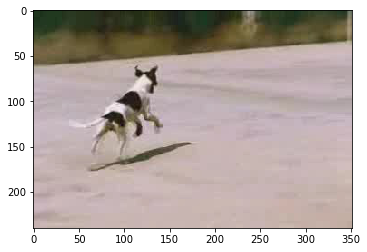

In [5]:
# first frame
img1 = Image.open(frame_name_list[0]).convert('RGB')#first frame
plt.imshow(img1)

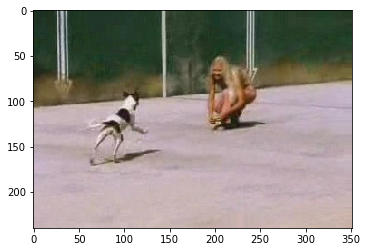

In [55]:
# second frame
img2 = Image.open(frame_name_list[50]).convert('RGB')#first frame
plt.imshow(img2)

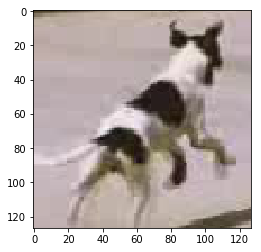

In [56]:
# now get z(template) in first frame
bbox = init_bb
zbox = get_zbox(bbox,0.25)#as paper mentioned, p = 0.5
# now we see the dog!
z = gen_xz(img1,zbox,to='z')
plt.imshow(z)

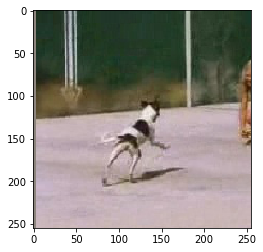

In [57]:
# and x(search region)
xbox = get_xbox(zbox)
x = gen_xz( img2, xbox,to = 'x')
plt.imshow(x)

In [58]:
# transform z and x to tensor
tz = 255.0 * TF.to_tensor(z).unsqueeze(0)
tz = tz.cuda()
tx = 255.0 * TF.to_tensor(x).unsqueeze(0)
tx = tx.cuda()
# go through the siam model
tz = siam.forward_once(tz)
tx = siam.forward_once(tx)

In [59]:
# generate the scores map by using xcorrelation
scores = siam.xcorr(tz,tx)

In [60]:
# now we see the shape of scores
print scores.shape

torch.Size([1, 1, 17, 17])


In [61]:
# and the shape of tz,tx
print tz.shape, tx.shape

torch.Size([1, 32, 6, 6]) torch.Size([1, 32, 22, 22])


In [62]:
scores = scores.data.cpu().numpy()[0][0]

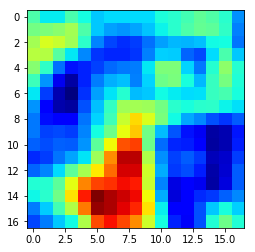

In [63]:
# see the original scores
plt.imshow(scores,cmap=CM.jet)

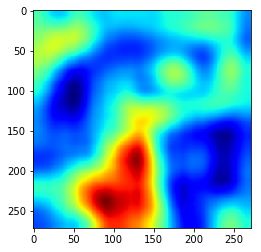

In [64]:
# well, you need to resize it to 272,272
scores = cv2.resize(scores,(272,272), interpolation=cv2.INTER_CUBIC)
plt.imshow(scores,cmap=CM.jet)

In [65]:
# and we find the maximum position in the map
p = np.asarray(np.unravel_index(np.argmax(scores), np.shape(scores)))
print p

[238  91]


In [66]:
# because we do the convolutional operation on 22*22 with 6*6 kernel
# so the output is 17*17 right?
# thus, in the original input layer,
# if we want to generate an 17*17 output with 255*255 search region and 127*127 template,
# we need to make the stride as 8
# so we resize the 17*17 to 272*272
# and the distance in the output should be 2 times than the distance in original x
center = float(272 - 1) / 2
disp_in_area = p - center
disp_in_xcrop = disp_in_area * 0.5

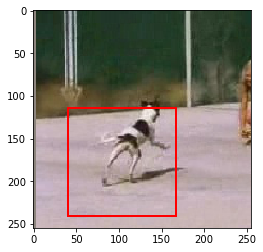

In [67]:
#show the predict z in x
show_frame_boxes(x,[Rectangle(disp_in_xcrop[1]+126,disp_in_xcrop[0]+126,127,127)])

In [68]:
# resize the position to frame-scales
disp_in_frame = disp_in_xcrop *  xbox.width / 255

In [69]:
# we need to reverse the p to Image position
pred_zbox = Rectangle(disp_in_frame[1]+zbox.x,disp_in_frame[0]+zbox.y,zbox.width,zbox.height)
# and find the bbox!
pred_bbox = Rectangle(pred_zbox.x,pred_zbox.y,bbox.width,bbox.height)

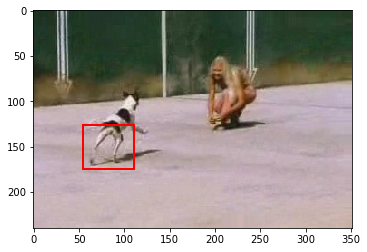

In [70]:
show_frame_boxes(img2 , [pred_bbox])